In [1]:
save_figures = True
save_tables = True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from linearmodels import PanelOLS
from linearmodels.panel import RandomEffects

In [3]:
df_tweets = pd.read_csv('../datasets/twitter/tweets_location_corrected.csv', parse_dates=['date'])
df_tweets['date'] = df_tweets['date'].dt.tz_localize(None)

In [4]:
df_ipc = pd.read_csv('../datasets/twitter/IPC_somalia.csv', parse_dates=['date'])
df_ipc['3_plus'] = df_ipc['3_plus'].str.rstrip('%').astype('int')
df_ipc['3_plus_proj'] = df_ipc['3_plus_proj'].str.rstrip('%').astype('int')

In [5]:
df = pd.concat([df_tweets[['date', 'sentiment_label', 'sentiment_score', 'long', 'lat', 'category_label', 'category_score', 'emotion_score']], pd.get_dummies(df_tweets['sentiment_label']), pd.get_dummies(df_tweets['emotion_label'])], axis=1)
df['is_news'] = df['category_label'] == 'news_&_social_concern'
df['is_personal'] = df['category_label'] == 'diaries_&_daily_life'

In [6]:
# euclidian distnace, no curvature taken into account
def distance(x, y):
    return np.sqrt(np.sum((x - y)**2, axis=1))

# inverse distance weighting
def idw(x, y,  power, epsilon=0):
    a = (1/(distance(x, y) + epsilon))**power
    return a/np.sum(a)

In [24]:
corr_data = []
corr_between_data = []
for epsilon in [0.25, 0.5, 1, 2, 4, 8]:
    for pow in [0.25, 0.5, 1, 2, 4, 8]: 
        data = construct_data(3, 4, dropoff_pow=pow, epsilon=epsilon)
        corrs_between = data.groupby('date')[['is_news', '3_plus']].apply(lambda x: x.corr().iloc[0, 1]).dropna()
        corr_between_data.append([epsilon, pow, corrs_between.mean()])

corr_between_data =  pd.DataFrame(corr_between_data)
corr_between_data.columns = ['epsilon', 'power', 'mean between-correlation']

<AxesSubplot:xlabel='power', ylabel='mean between-correlation'>

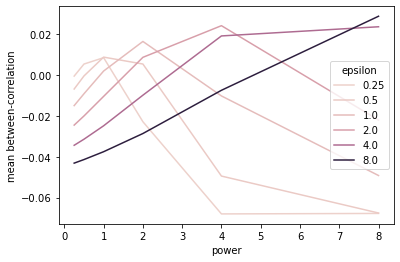

In [26]:
fig, ax = plt.subplots()
sns.lineplot(x='power', y='mean between-correlation', hue='epsilon', data=corr_between_data)

In [7]:
def construct_data(lag, size, date_range=[], dropoff_pow=1, epsilon=0.1, no_drop=False):
    data = []
    lag = pd.DateOffset(months=lag)
    size = pd.DateOffset(months=size)
    
    if date_range:
        date_mask = (df_ipc['date'] >= pd.to_datetime(date_range[0])) & (df_ipc['date'] <= pd.to_datetime(date_range[1]))
        df_iterator = df_ipc[date_mask].iterrows()
    else:
        df_iterator = df_ipc.iterrows()
        
    for idx, row in df_iterator:
        mask = (df['date'] <= row['date'] - lag) &\
            (df['date'] >= row['date'] - lag - size)
        ipc_mask = (df_ipc['area'] == row['area']) & (df_ipc['date'] <= row['date'] - lag) & (df_ipc['date'] >= row['date'] - lag - size)
        temp_df = df[mask]
        if len(temp_df) < 1:
            continue
        coords = temp_df[['lat', 'long']].to_numpy()
        # add a small distance to coords to prevent division by zero
        w = idw(coords, np.array([row['lat'], row['long']]), dropoff_pow, epsilon)
        data.append([
                np.average(temp_df['Positive'] * temp_df['sentiment_score'], weights=w),
                np.average(temp_df['Negative'] * temp_df['sentiment_score'], weights=w), 
                np.average(temp_df['Neutral'] * temp_df['emotion_score'], weights=w), 
                np.average(temp_df['anger'] * temp_df['emotion_score'], weights=w), 
                np.average(temp_df['joy'] * temp_df['emotion_score'], weights=w), 
                np.average(temp_df['optimism'] * temp_df['emotion_score'], weights=w), 
                np.average(temp_df['sadness'] * temp_df['emotion_score'], weights=w),
                np.average(temp_df['is_news'] * temp_df['category_score'], weights=w),
                np.average(temp_df['is_personal'] * temp_df['category_score'], weights=w),
                df_ipc[ipc_mask]['3_plus_proj'].mean()/100,
                df_ipc[ipc_mask]['3_plus'].mean()/100,
                row['3_plus']/100,
                row['area'],
                row['date']])
        
    data = pd.DataFrame(data)
    data.columns = ['pos', 'neg', 'neutral', 'anger','joy' ,'optimism', 'sadness', 'is_news', 'is_personal', '3_plus_proj', '3_plus_past', '3_plus', 'dis', 'date']
    if no_drop:
        return data
    return data.dropna()

In [8]:
data = construct_data(1, 1, dropoff_pow=1, epsilon=0.1, no_drop=True)
corrs_between = data.groupby('date')[['is_news', '3_plus']].apply(lambda x: x.corr().iloc[0, 1]).dropna()
for i in range(2, 9):
    data = construct_data(i, 1, dropoff_pow=1, epsilon=0.1, no_drop=True)
    corrs_between = pd.concat([corrs_between, data.groupby('date')[['is_news', '3_plus']].apply(lambda x: x.corr().iloc[0, 1]).dropna()])

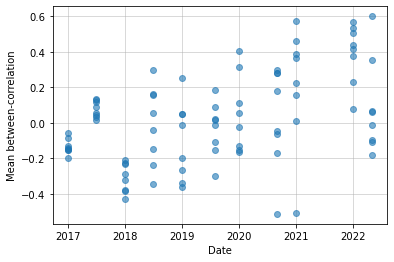

In [9]:
df_between = pd.DataFrame(corrs_between, columns=['Mean between-correlation']).reset_index()
fig, ax = plt.subplots()
ax.scatter(x=df_between['date'], y=df_between['Mean between-correlation'], alpha=0.6, zorder=10000)
ax.set_ylabel('Mean between-correlation')
ax.set_xlabel('Date')
ax.grid(alpha=0.6)

fig.savefig('../figures/between_corr_vs_date.pdf', format='pdf')

In [10]:
data = construct_data(3, 4, dropoff_pow=1, epsilon=0.1)
data = data.set_index(['dis', 'date'])
X, y = data.loc[:, ['is_news', '3_plus_proj']], data.iloc[:, -1]
reg = PanelOLS(y, X, entity_effects=True).fit(cov_type='clustered', cluster_time=True)
reg

Dep. Variable:,3_plus,R-squared:,0.3029
Estimator:,PanelOLS,R-squared (Between):,0.3750
No. Observations:,530,R-squared (Within):,0.3029
Date:,"Thu, Aug 11 2022",R-squared (Overall):,-0.0591
Time:,23:53:19,Log-likelihood,631.40
Cov. Estimator:,Clustered,,
,,F-statistic:,94.723
Entities:,92,P-value,0.0000
Avg Obs:,5.7609,Distribution:,"F(2,436)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,8.0843


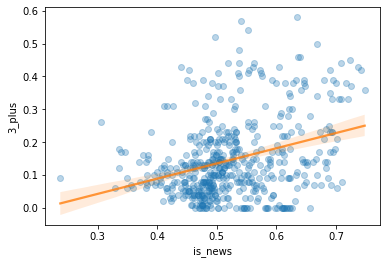

In [12]:
fig, ax = plt.subplots()

sns.regplot(x='is_news', y='3_plus', data=data, scatter_kws={'alpha': 0.3},  line_kws={'color': 'tab:orange', 'alpha': 0.8})

fig.savefig('../figures/is_news_3_plus_reg_scatter.pdf', format='pdf')

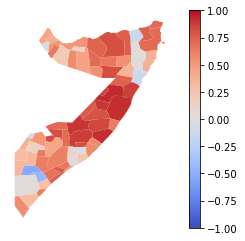

In [13]:
from auxiliary_code.helper_functions import *
df_shape = get_shape_file('../geography/Somalia/Som_Admbnda_Adm2_UNDP.shp')
corrs = data.groupby('dis')[['is_news', '3_plus']].apply(lambda x: x.corr().iloc[0, 1]).dropna()

fig, ax = plt.subplots()
df_shape.merge(corrs.rename('correlation'), left_index=True, right_index=True).plot('correlation',cmap='coolwarm', legend=True, vmin=-1, vmax=1, ax=ax)
plt.axis('off');

fig.savefig('../figures/corr_is_news_spatial.pdf', format='pdf')

In [14]:
coefs = []
for lag in range(1, 7):
    for size in range(1, 7): 
        if(lag + size <= 6):
            continue      
        
        data = construct_data(lag, size, dropoff_pow=1, epsilon=0.1)
        data = data.set_index(['dis', 'date'])
        X, y = data.loc[:, ['is_news', '3_plus_proj']], data.iloc[:, -1]
        reg = PanelOLS(y, X, entity_effects=True).fit(cov_type='clustered', cluster_time=True)
        coefs.append([lag, size, reg.params[0], reg.pvalues[0]])
        
coefs = pd.DataFrame(coefs)
coefs.columns = ['Lag', 'Window size', 'Coefficient', 'P-value']
coefs = coefs.set_index(['Lag', 'Window size'])

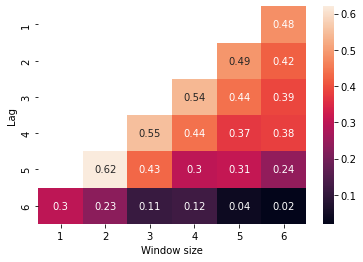

In [15]:
fig, ax = plt.subplots()
sns.heatmap(coefs['Coefficient'].unstack().round(2), annot=True, ax=ax)

fig.savefig('../figures/coefficient_matrix_is_news.pdf', format='pdf')

In [16]:
within_corrs = []
for lag in range(1, 7):
    for size in range(1, 7):      
        data = construct_data(lag, size, dropoff_pow=1, epsilon=0.1, no_drop=True)
        corrs = data[['dis', 'is_news', '3_plus']].dropna().groupby('dis').apply(lambda x: x.corr().iloc[0, 1]).dropna()
        within_corrs.append([lag, size, corrs.mean()])
ayy = within_corrs[:]
within_corrs = pd.DataFrame(ayy)
within_corrs.columns = ['Lag', 'Window size', 'Correlation']
within_corrs = within_corrs.set_index(['Lag', 'Window size'])

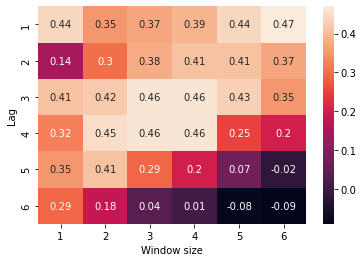

In [17]:
fig, ax = plt.subplots()
sns.heatmap(within_corrs['Correlation'].unstack().round(2), annot=True)
fig.savefig('../figures/mean_within_corr_matrix_is_news.pdf', format='pdf')

In [18]:
coefs = []
for year in [2017, 2018, 2019, 2020]:
    date_range = [f'{year}-01-01', f'{year+2}-06-01']
    data = construct_data(3, 4, date_range=date_range, dropoff_pow=1, epsilon=0.1)
    data = data.set_index(['dis', 'date'])
    X, y = data.loc[:, ['is_news', '3_plus_proj']], data.iloc[:, -1]
    reg = PanelOLS(y, X, entity_effects=True).fit(cov_type='clustered', cluster_time=True)
    coefs.append([" to ".join(date_range), reg.params[0], reg.pvalues[0], reg.corr_squared_within, reg.rsquared_between, reg.rsquared_overall])
        
coefs = pd.DataFrame(coefs)

coefs.columns = ['Period', 'Coefficient', 'P-value', 'R-Squared within', 'R-Squared between', 'R-squared']

In [19]:
data = construct_data(3, 4, dropoff_pow=1, epsilon=0.1)
data = data.set_index(['dis', 'date'])
X, y = data.loc[:, ['is_news', 'pos', '3_plus_proj']], data.iloc[:, -1]
X['is_news * pos'] = X['is_news'] * X['pos']
reg = PanelOLS(y, X, entity_effects=True).fit(cov_type='clustered', cluster_time=True)
reg

Dep. Variable:,3_plus,R-squared:,0.3127
Estimator:,PanelOLS,R-squared (Between):,-2.2724
No. Observations:,530,R-squared (Within):,0.3127
Date:,"Thu, Aug 11 2022",R-squared (Overall):,-3.8870
Time:,23:59:23,Log-likelihood,635.17
Cov. Estimator:,Clustered,,
,,F-statistic:,49.369
Entities:,92,P-value,0.0000
Avg Obs:,5.7609,Distribution:,"F(4,434)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,5.9332


In [20]:
data = construct_data(3, 4, dropoff_pow=1, epsilon=0.1)
data = data.set_index(['dis', 'date'])
X, y = data.loc[:, ['is_news', 'sadness', '3_plus_proj']], data.iloc[:, -1]
X['is_news * sadness'] = X['is_news'] * X['sadness']
reg = PanelOLS(y, X, entity_effects=True).fit(cov_type='clustered', cluster_time=True)
print(reg.summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}     &      3\_plus       & \textbf{  R-squared:         }   &      0.3374      \\
\textbf{Estimator:}         &      PanelOLS      & \textbf{  R-squared (Between):}  &     -1.7905      \\
\textbf{No. Observations:}  &        530         & \textbf{  R-squared (Within):}   &      0.3374      \\
\textbf{Date:}              &  Thu, Aug 11 2022  & \textbf{  R-squared (Overall):}  &     -1.9448      \\
\textbf{Time:}              &      23:59:29      & \textbf{  Log-likelihood     }   &      644.85      \\
\textbf{Cov. Estimator:}    &     Clustered      & \textbf{                     }   &                  \\
\textbf{}                   &                    & \textbf{  F-statistic:       }   &      55.247      \\
\textbf{Entities:}          &         92         & \textbf{  P-value            }   &      0.0000      \\
\textbf{Avg Obs:}           &       5.7609       & \textbf{  Distribution:      }   &     F(4,434)     \\


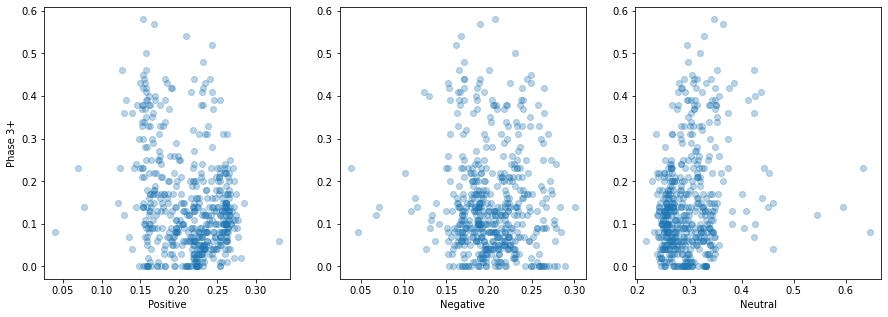

In [21]:
data = construct_data(3, 4, dropoff_pow=1, epsilon=0.1)


fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
cols = ['pos', 'neg', 'neutral']
names = ['Positive', 'Negative', 'Neutral']

for i, col in enumerate(cols):
    axs[i].scatter(x=data[col], y=data['3_plus'], alpha=0.3)
    axs[i].set_xlabel(names[i])
axs[0].set_ylabel('Phase 3+');
fig.savefig('../figures/sentiment_3_plus_scatter.pdf', format='pdf')

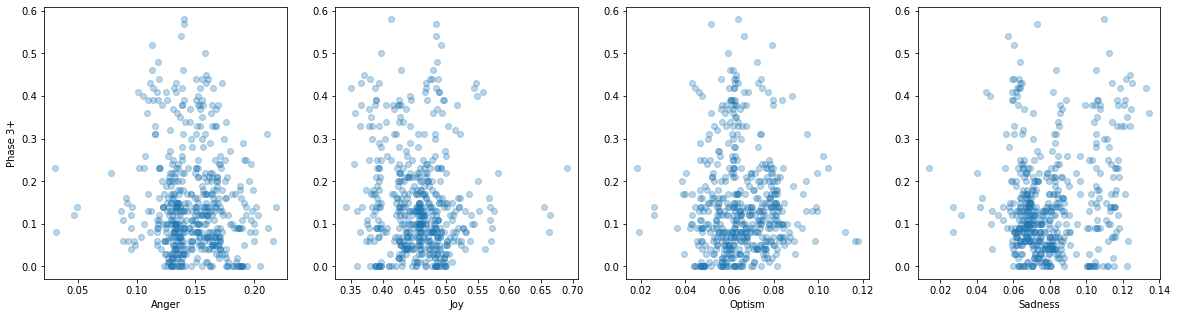

In [22]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
cols = ['anger','joy' ,'optimism', 'sadness']
names = ['Anger', 'Joy', 'Optism', 'Sadness']

for i, col in enumerate(cols):
    axs[i].scatter(x=data[col], y=data['3_plus'], alpha=0.3)
    axs[i].set_xlabel(names[i])
axs[0].set_ylabel('Phase 3+');
fig.savefig('../figures/emotion_3_plus_scatter.pdf', format='pdf')

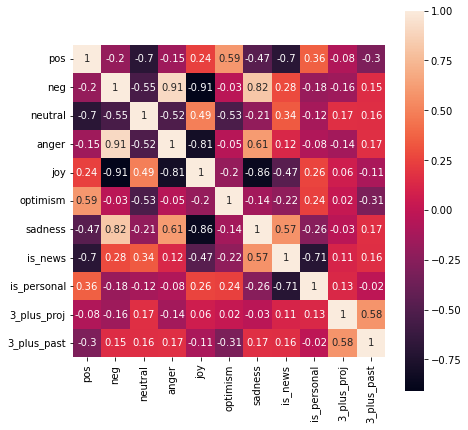

In [23]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(data.iloc[:, :-3].corr().round(2), annot=True, ax=ax)
ax.set_aspect('equal','box')

fig.savefig('../figures/correlation_twitter_features.pdf', format='pdf')